# 循环神经网络
本节介绍循环神经网络，下图展示了如何基于循环神经网络实现语言模型。我们的目的是基于当前的输入与过去的输入序列，预测序列的下一个字符。循环神经网络引入一个隐藏变量$H$，用$H_{t}$表示$H$在时间步$t$的值。$H_{t}$的计算基于$X_{t}$和$H_{t-1}$，可以认为$H_{t}$记录了到当前字符为止的序列信息，利用$H_{t}$对序列的下一个字符进行预测。
![Image Name](https://cdn.kesci.com/upload/image/q5jkm0v44i.png?imageView2/0/w/640/h/640)
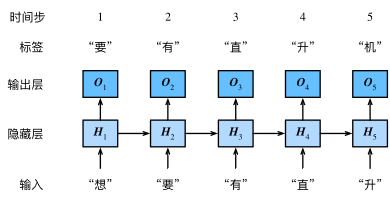

## 循环神经网络的构造

我们先看循环神经网络的具体构造。假设$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$是时间步$t$的小批量输入，$\boldsymbol{H}_t  \in \mathbb{R}^{n \times h}$是该时间步的隐藏变量，则：


$$
\boldsymbol{H}_t = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}  + \boldsymbol{b}_h).
$$


其中，$\boldsymbol{W}_{xh} \in \mathbb{R}^{d \times h}$，$\boldsymbol{W}_{hh} \in \mathbb{R}^{h \times h}$，$\boldsymbol{b}_{h} \in \mathbb{R}^{1 \times h}$，$\phi$函数是非线性激活函数。由于引入了$\boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}$，$H_{t}$能够捕捉截至当前时间步的序列的历史信息，就像是神经网络当前时间步的状态或记忆一样。由于$H_{t}$的计算基于$H_{t-1}$，上式的计算是循环的，使用循环计算的网络即循环神经网络（recurrent neural network）。

在时间步$t$，输出层的输出为：


$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q.
$$


其中$\boldsymbol{W}_{hq} \in \mathbb{R}^{h \times q}$，$\boldsymbol{b}_q \in \mathbb{R}^{1 \times q}$。


## 从零开始实现循环神经网络

我们先尝试从零开始实现一个基于字符级循环神经网络的语言模型，这里我们使用周杰伦的歌词作为语料，首先我们读入数据：

In [1]:
import torch
import torch.nn as nn
import time
import math
import sys
import random
sys.path.append("/home/kesci/input")
# import d2l_jay9460 as d2l

In [2]:
def load_data_jay_lyrics():
    with open('/home/kesci/input/jaychou_lyrics4703/jaychou_lyrics.txt') as f:
        corpus_chars = f.read()
    corpus_chars = corpus_chars.replace('\n', ' ').replace('\r', ' ')
    print(type(corpus_chars))  # str 类型
    corpus_chars = corpus_chars[0:10000]  # 只取前10000个字(符)做为训练语料
    idx_to_char = list(set(corpus_chars))
    char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
    vocab_size = len(char_to_idx)
    corpus_indices = [char_to_idx[char] for char in corpus_chars]
    return corpus_indices, char_to_idx, idx_to_char, vocab_size

In [3]:
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = load_data_jay_lyrics()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<class 'str'>


In [4]:
device

device(type='cpu')

In [5]:
print(vocab_size)

1027


### one-hot向量

我们需要将字符表示成向量，这里采用one-hot向量。假设词典大小是$N$，每次字符对应一个从$0$到$N-1$的唯一的索引，则该字符的向量是一个长度为$N$的向量，若字符的索引是$i$，则该向量的第$i$个位置为$1$，其他位置为$0$。下面分别展示了索引为0和2的one-hot向量，向量长度等于词典大小。

In [6]:
def one_hot(x, n_class, dtype=torch.float32):
    result = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)  # shape: (n, n_class)
    # x.shape为tensor([0, 2])，x.long().view(-1, 1)的shape为torch.Size([2, 1])
    # 即 tensor([[one],
    #            [two]])
    result.scatter_(dim=1, index=x.long().view(-1, 1), src=torch.tensor(1))  # result[i, x[i, 0]] = 1
    return result
    
x = torch.tensor([0, 2])
x_one_hot = one_hot(x, vocab_size)  # vocab_size = 1027
print(x_one_hot)
print(x_one_hot.shape)
print(x_one_hot.sum(axis=1))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
torch.Size([2, 1027])
tensor([1., 1.])


In [7]:
# tensor.scatter_() 示例
import torch
 
input = torch.randn(2, 4)
print(input)
output = torch.zeros(2, 5)
index = torch.tensor([[3, 1, 2, 0], [1, 2, 0, 3]])
output = output.scatter(dim=1, index=index, src=input)
print(output)

tensor([[ 0.6494,  0.6231,  1.2853, -1.8177],
        [ 1.4094,  0.7331,  1.0617, -0.3743]])
tensor([[-1.8177,  0.6231,  1.2853,  0.6494,  0.0000],
        [ 1.0617,  1.4094,  0.7331, -0.3743,  0.0000]])


[tensor.scatter_()用法](https://blog.csdn.net/qq_39004117/article/details/95665418)

### 三维
```
out[index[i][j][k]][j][k] = src[i][j][k]  # if dim == 0
out[i][index[i][j][k]][k] = src[i][j][k]  # if dim == 1
out[i][j][index[i][j][k]] = src[i][j][k]  # if dim == 2
```

### 二维
```
out[index[i][j]][j] = src[i][j]  # if dim == 0
out[i][index[i][j]] = src[i][j]  # if dim == 1

例如：上面的例子，dim = 1 ， a -> b 表示将a的值赋予b，即b = a
input[0][0] -> out[0][index[0][0]] -> out[0][3] = -1.1520 即 out[0][3] = input[0][0]
input[0][1] -> out[0][index[0][1]] -> out[0][1] =  1.6093 即 out[0][1] = input[0][1]
input[0][2] -> out[0][index[0][2]] -> out[0][2] =  1.3236 即 out[0][2] = input[0][2]
input[0][3] -> out[0][index[0][3]] -> out[0][0] = -0.8939 即 out[0][0] = input[0][3]

```

我们每次采样的小批量的形状是（批量大小, 时间步数）。下面的函数将这样的小批量变换成数个形状为（批量大小, 词典大小）的矩阵，矩阵个数等于时间步数。也就是说，时间步$t$的输入为$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$，其中$n$为批量大小，$d$为词向量大小，即one-hot向量长度（词典大小）。

In [8]:
def to_onehot(X, n_class):  # n_class 为类别数量，这里指vocab_size的大小
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

X = torch.arange(10).view(2, 5)
print('1:', X.shape)
inputs = to_onehot(X, vocab_size)  # vocab_size = 1027
print('2:', len(inputs), inputs[0].shape)  # inputs为list, [tensor2d, rensor2d, ... ]
print('3:', inputs[1])
print('4:', X[:, 1])

1: torch.Size([2, 5])
2: 5 torch.Size([2, 1027])
3: tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
4: tensor([1, 6])


### 初始化模型参数


In [9]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size  # vocab_size = 1027
# num_inputs: d
# num_hiddens: h, 隐藏单元的个数是超参数
# num_outputs: q

def get_params():
    def _one(shape):
        param = torch.zeros(shape, device=device, dtype=torch.float32)
        nn.init.normal_(param, 0, 0.01)
        # 将这个parameter绑定到这个module里面
        # (net.parameter()中就有这个绑定的parameter，所以在参数优化的时候可以进行优化的)
        # 这里的param就变成了模型的一部分
        # Reference: https://www.jianshu.com/p/d8b77cc02410
        return torch.nn.Parameter(param)

    # 隐藏层参数
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device))
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device))
    return (W_xh, W_hh, b_h, W_hq, b_q)

### 定义模型

函数`rnn`用循环的方式依次完成循环神经网络每个时间步的计算。


In [10]:
def rnn(inputs, state, params):
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state  # 隐藏变量H初始化为全0
    outputs = []
    for X in inputs:
        # X.shape = (2*1027), W_xh.shape = (num_inputs, num_hiddens) = (1027*256)
        # H.shape = (2*256)
        # W_hh.shape = (num_hiddens, num_hiddens) = (256*256)
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        # H.shape = (2*256)
        # W_hq = (num_hiddens, num_outputs) = (256*1027)
        Y = torch.matmul(H, W_hq) + b_q  # Y.shape = X.shape = (2*1027)
        outputs.append(Y)
    return outputs, (H,)

**函数init_rnn_state初始化隐藏变量，这里的返回值是一个元组。：
**

In [11]:
# 隐藏变量初始化为全0
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

做个简单的测试来观察输出结果的个数（时间步数），以及第一个时间步的输出层输出的形状和隐藏状态的形状。

In [12]:
len(init_rnn_state(X.shape[0], num_hiddens, device))

1

In [13]:
type(init_rnn_state(X.shape[0], num_hiddens, device))  # 返回的是(tensor, )的形式

tuple

In [14]:
mid, = init_rnn_state(X.shape[0], num_hiddens, device)
mid.shape

torch.Size([2, 256])

In [15]:
print(X.shape)
print(num_hiddens)
print(vocab_size)
state = init_rnn_state(X.shape[0], num_hiddens, device)  # 隐藏变量H初始化为全0
inputs = to_onehot(X.to(device), vocab_size)
params = get_params()
outputs, state_new = rnn(inputs, state, params)
print(len(inputs), inputs[0].shape)
print(len(outputs), outputs[0].shape)
print(len(state), state[0].shape)
print(len(state_new), state_new[0].shape)

torch.Size([2, 5])
256
1027
5 torch.Size([2, 1027])
5 torch.Size([2, 1027])
1 torch.Size([2, 256])
1 torch.Size([2, 256])


### 裁剪梯度

循环神经网络中较容易出现梯度衰减或梯度爆炸，这会导致网络几乎无法训练。裁剪梯度（clip gradient）是一种应对梯度爆炸的方法。假设我们把所有模型参数的梯度拼接成一个向量 $\boldsymbol{g}$，并设裁剪的阈值是$\theta$。裁剪后的梯度


$$
 \min\left(\frac{\theta}{\|\boldsymbol{g}\|}, 1\right)\boldsymbol{g}
$$


的$L_2$范数不超过$\theta$。


In [16]:
def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()  # norm 是一个浮点数
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

### 定义预测函数

以下函数基于前缀`prefix`（含有数个字符的字符串）来预测接下来的`num_chars`个字符。这个函数稍显复杂，其中我们将循环神经单元`rnn`设置成了函数参数，这样在后面小节介绍其他循环神经网络时能重复使用这个函数。


In [17]:
def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    """
    num_chars: 要预测的字符串的长度（不包含前缀长度）
    """
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]   # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        # 将上一时间步的输出作为当前时间步的输入
        # X 为只含有一个元素的list， [ torch.Size([1, 1027]) ]， Y也是[ torch.Size([1, 1027]) ]
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)  # idx -> one-hot
        
        # 计算输出和更新隐藏状态
        (Y, state) = rnn(X, state, params)
        
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])  # 下一个时间步的输入是 prefix里的字符
        else:
            output.append(Y[0].argmax(dim=1).item())   # 下一个时间步的输入是 当前的最佳预测字符
    return ''.join([idx_to_char[i] for i in output])

我们先测试一下`predict_rnn`函数。我们将根据前缀“分开”创作长度为10个字符（不考虑前缀长度）的一段歌词。因为模型参数为随机值，所以预测结果也是随机的。

In [18]:
predict_rnn('分开', 10, rnn, params, init_rnn_state, num_hiddens, vocab_size,
            device, idx_to_char, char_to_idx)

'分开征驳怪宇蝪悄拽垂白袋'

### 困惑度

我们通常使用困惑度（perplexity）来评价语言模型的好坏。回忆一下[“softmax回归”](../chapter_deep-learning-basics/softmax-regression.ipynb)一节中交叉熵损失函数的定义。困惑度是对交叉熵损失函数做指数运算后得到的值。特别地，

* 最佳情况下，模型总是把标签类别的概率预测为1，此时困惑度为1；
* 最坏情况下，模型总是把标签类别的概率预测为0，此时困惑度为正无穷；
* 基线情况下，模型总是预测所有类别的概率都相同，此时困惑度为类别个数。

显然，任何一个有效模型的困惑度必须小于类别个数。在本例中，困惑度必须小于词典大小`vocab_size`。

### 定义模型训练函数

跟之前章节的模型训练函数相比，这里的模型训练函数有以下几点不同：

1. 使用困惑度评价模型。
2. 在迭代模型参数前裁剪梯度。
3. 对时序数据采用不同采样方法将导致隐藏状态初始化的不同。

In [19]:
# 随机采样
def data_iter_random(corpus_indices, batch_size, num_steps, device=None):
    # 减1是因为输出的索引x是相应输入的索引y加1
    num_examples = (len(corpus_indices) - 1) // num_steps
    epoch_size = num_examples // batch_size
    example_indices = list(range(num_examples))
    random.shuffle(example_indices)

    # 返回从pos开始的长为num_steps的序列
    def _data(pos):
        return corpus_indices[pos: pos + num_steps]
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for i in range(epoch_size):
        # 每次读取batch_size个随机样本
        i = i * batch_size
        batch_indices = example_indices[i: i + batch_size]
        X = [_data(j * num_steps) for j in batch_indices]
        Y = [_data(j * num_steps + 1) for j in batch_indices]
        yield torch.tensor(X, dtype=torch.float32, device=device), torch.tensor(Y, dtype=torch.float32, device=device)
        


In [20]:
# 相邻采样
def data_iter_consecutive(corpus_indices, batch_size, num_steps, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    corpus_indices = torch.tensor(corpus_indices, dtype=torch.float32, device=device)
    data_len = len(corpus_indices)
    batch_len = data_len // batch_size
    indices = corpus_indices[0: batch_size*batch_len].view(batch_size, batch_len)
    epoch_size = (batch_len - 1) // num_steps
    for i in range(epoch_size):
        i = i * num_steps
        X = indices[:, i: i + num_steps]
        Y = indices[:, i + 1: i + num_steps + 1]
        yield X, Y

In [21]:
def sgd(params, lr, batch_size):
    # 为了和原书保持一致，这里除以了batch_size，但是应该是不用除的，因为一般用PyTorch计算loss时就默认已经
    # 沿batch维求了平均了。
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [22]:
corpus_indices[:10], len(corpus_indices)

([40, 129, 981, 553, 781, 100, 661, 40, 129, 856], 10000)

In [24]:
def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    """
    num_steps: 每次采样的样本长度
    is_random_iter: bool类型, True表示随机采样，False表示相邻采样
    pred_period:  每训练多少次 输出一次结果，这里是50
    pred_len:  给出前缀词prefixes，预测后面的pred_len个词
    prefixes: 前缀词
    """
    if is_random_iter:
        data_iter_fn = data_iter_random
    else:
        data_iter_fn = data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:  # 否则需要使用detach函数从计算图分离隐藏状态，这时的隐藏状态只初始为全0，
                # 每次迭代计算，不参与梯度计算
                for s in state:
                    s.detach_()
            # inputs是num_steps个形状为(batch_size, vocab_size)的矩阵
            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成形状为
            # (num_steps * batch_size,)的向量，这样跟输出的行一一对应
            y = torch.flatten(Y.T)
            # 使用交叉熵损失计算平均分类误差，注意CrossEntropy用法
            l = loss(outputs, y.long())  # torch.long() 将tensor投射为long类型
            # print(outputs.shape, y.long().shape)  # torch.Size([1120, 1027]) torch.Size([1120])
            
            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))

### 训练模型并创作歌词

现在我们可以训练模型了。首先，设置模型超参数。我们将根据前缀“分开”和“不分开”分别创作长度为50个字符（不考虑前缀长度）的一段歌词。我们每过50个迭代周期便根据当前训练的模型创作一段歌词。

In [25]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 250, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']

下面采用随机采样训练模型并创作歌词。

In [51]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 67.313510, time 0.87 sec
 - 分开 我想要你想你 我不要你的爱 我不要你的爱 我不要你的爱 我不要你的爱 我不要你的爱 我不要你的爱 
 - 不分开 爱要你的生写 我不要你不 我不要再想你 我不要你的爱我 我想要你不 我不要再想你 我不要你的爱我 
epoch 100, perplexity 9.733288, time 0.68 sec
 - 分开 一颗用 有不的让我 红的可爱女人 透坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯
 - 不分开堡 我后能 你爱我 我想就这样牵着你的手不放开 爱可不 你给的让我疯红的可爱女人 坏柔的让我疯狂的可
epoch 150, perplexity 2.764272, time 0.68 sec
 - 分开 爱想是没有 二我温红乡球信命我 在散一 几步时不起球 它说哈兮我妈轻 却我现 你沉已 一壶两 旧沉
 - 不分开期 我后你好 你打我妈 这样 一个意酒 戒指好哭 耍不夜梦 你一定空 你自不通 你不懂 连一句珍重 
epoch 200, perplexity 1.532843, time 0.67 sec
 - 分开 爱在心 一步两步三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背默默许下心愿 看远方的星是否
 - 不分开扫把的胖女巫 用拉丁文念咒语啦啦呜 她养的黑猫笑起来像哭 啦啦啦呜 我妈我将说活你 一壶好酒有再不了
epoch 250, perplexity 1.281982, time 0.69 sec
 - 分开 爱什么 一步两步三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背默默许下心愿 看远方的星如果
 - 不分开期 然后将过去 慢慢温习 让我爱上你 那场悲剧 是你完美演出的一场戏 宁愿心碎哭泣 再狠狠忘记 你爱


## 可以发现 不同的初始化参数，最后输出的结果是类似的

In [54]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 67.800381, time 0.71 sec
 - 分开 我不要再想你的让我 甩的可爱女人 哼知的觉 我已了这 你有我有 你想了这 你有我有 你想了这 你有
 - 不分开 我不要再想 我不要的可爱女人 透坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的
epoch 100, perplexity 10.171657, time 0.78 sec
 - 分开 一颗两双三棍我单妈 我说的话 你知的让我面红的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的
 - 不分开吗 我不能再想你 不知不觉 你已经离 我给后知 你知的让 我跟定努 恨果的外 你人放空 你一定空 在
epoch 150, perplexity 2.862187, time 0.79 sec
 - 分开 一直心停子  让悔着对里 一天 这截棍 后词不  一些风霜凉  什悔文对 有故伦头 在一场纵  没
 - 不分开吗 我叫你爸 你知我有 这样的让我面红的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人
epoch 200, perplexity 1.577382, time 0.77 sec
 - 分开 干愿底不里 谁话都乌难 别里什么奇怪的事都有 包括像猫的狗 印地安老斑鸠 平常话不多 除非是乌鸦抢
 - 不分开扫 我不能爸生  没有你烦我有多难恼多难熬  穿过云层 我试著努力向你奔跑 爱才送到 你却已在节人怀
epoch 250, perplexity 1.323946, time 0.73 sec
 - 分开 干时的老丽 你的完美主义 太彻底我的泪真幽动 在红再重演经 哼哼哈兮 如果我有轻功 飞檐走壁 为人
 - 不分开简 然后将过去 慢慢温习 让我爱上你 那场悲剧 是你完美演出的一场戏 宁愿心碎哭泣 再狠狠忘记 你爱


接下来采用相邻采样训练模型并创作歌词。

In [58]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, False, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 58.474331, time 0.62 sec
 - 分开 我想要你 你你的外 如果用人 泪谁一人 泪谁一人 泪果一人 泪谁一人 泪谁一人 泪果一人 泪谁一人
 - 不分开 我想要你 你你了外 我想一直 泪你一直 如果一人 泪谁一人 泪谁一人 泪果一人 泪谁一人 泪谁一人
epoch 100, perplexity 7.376631, time 0.64 sec
 - 分开 我说想这生活 我想好好 又我的外婆家 一起看着的牛肉 我说店小二 三两银够不  没有你在我有多 就
 - 不分开柳 你不经离 我想说带 在让己空 我有的梦 我面著带节人 后知后觉 快使了一个棍 哼哼哈兮 快使用双
epoch 150, perplexity 2.122068, time 0.69 sec
 - 分开 我 想带你骑棒车 我这想你和忧我妈妈 为才你手不会痛吗 不要我这做得想 但那伦我 经来 那壶我的后
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生
epoch 200, perplexity 1.285781, time 0.63 sec
 - 分开 我叫想这样对 我静带你 回我的外婆家 一起看着日落 一直到我们都睡着 我想就这样牵着你的手不放开 
 - 不分开觉太就多 泪说你 有我眼好看着  别人了其快我 甩散球 快给我 印你说那 说我马直是 我一直 一烧空
epoch 250, perplexity 1.212777, time 0.68 sec
 - 分开 在候跟 娘属我 印地安的传说 还真是 瞎透了 什么都有 这故之中 都隐作痛 我不懂受我 我不懂很想
 - 不分开觉太经天 不要你多手 让我却依不打 篮后在这里 除非是乌鸦抢了它的窝 它在灌木丛旁邂逅 一只令它心仪


## 循环神经网络的简介实现

### 定义模型

我们使用Pytorch中的`nn.RNN`来构造循环神经网络。在本节中，我们主要关注`nn.RNN`的以下几个构造函数参数：

* `input_size` - The number of expected features in the input x
* `hidden_size` – The number of features in the hidden state h
* `nonlinearity` – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
* `batch_first` – If True, then the input and output tensors are provided as (batch_size, num_steps, input_size). Default: False

这里的`batch_first`决定了输入的形状，我们使用默认的参数`False`，对应的输入形状是 (num_steps, batch_size, input_size)。

`forward`函数的参数为：

* `input` of shape (num_steps, batch_size, input_size): tensor containing the features of the input sequence. 
* `h_0` of shape (num_layers * num_directions, batch_size, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided. If the RNN is bidirectional, num_directions should be 2, else it should be 1.

`forward`函数的返回值是：

* `output` of shape (num_steps, batch_size, num_directions * hidden_size): tensor containing the output features (h_t) from the last layer of the RNN, for each t.
* `h_n` of shape (num_layers * num_directions, batch_size, hidden_size): tensor containing the hidden state for t = num_steps.

现在我们构造一个`nn.RNN`实例，并用一个简单的例子来看一下输出的形状。

In [71]:
rnn_layer = nn.RNN(input_size=vocab_size, hidden_size=num_hiddens)
num_steps, batch_size = 35, 2
X = torch.rand(num_steps, batch_size, vocab_size)
state = None
Y, state_new = rnn_layer(X, state)
print(X.shape, Y.shape, state_new.shape)
# 这里Y.shape的最后一个维度为num_hiddens

torch.Size([35, 2, 1027]) torch.Size([35, 2, 256]) torch.Size([1, 2, 256])


我们定义一个完整的基于循环神经网络的语言模型。

In [72]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.hidden_size = rnn_layer.hidden_size * (2 if rnn_layer.bidirectional else 1) 
        self.vocab_size = vocab_size
        self.dense = nn.Linear(self.hidden_size, vocab_size)  # 这里的vocab_size=1027为output.shape的最后一维

    def forward(self, inputs, state):
        # inputs.shape: (batch_size, num_steps)
        X = to_onehot(inputs, vocab_size)
        X = torch.stack(X)  # X.shape: (num_steps, batch_size, vocab_size)
        hiddens, state = self.rnn(X, state)
        hiddens = hiddens.view(-1, hiddens.shape[-1])  # hiddens.shape: (num_steps * batch_size, hidden_size)
        output = self.dense(hiddens)
        return output, state

类似的，我们需要实现一个预测函数，与前面的区别在于前向计算和初始化隐藏状态。

In [73]:
def predict_rnn_pytorch(prefix, num_chars, model, vocab_size, device, idx_to_char,
                      char_to_idx):
    state = None
    output = [char_to_idx[prefix[0]]]  # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        X = torch.tensor([output[-1]], device=device).view(1, 1)
        (Y, state) = model(X, state)  # 前向计算不需要传入模型参数
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(Y.argmax(dim=1).item())
    return ''.join([idx_to_char[i] for i in output])

使用权重为随机值的模型来预测一次。

In [74]:
model = RNNModel(rnn_layer, vocab_size).to(device)
predict_rnn_pytorch('分开', 10, model, vocab_size, device, idx_to_char, char_to_idx)

'分开放雨直直直直恍恍恍翻'

接下来实现训练函数，这里只使用了相邻采样。

In [75]:
def train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(num_epochs):
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_consecutive(corpus_indices, batch_size, num_steps, device) # 相邻采样
        state = None
        for X, Y in data_iter:
            if state is not None:
                # 使用detach函数从计算图分离隐藏状态
                if isinstance (state, tuple): # LSTM, state:(h, c)  
                    state[0].detach_()
                    state[1].detach_()
                else: 
                    state.detach_()
            (output, state) = model(X, state) # output.shape: (num_steps * batch_size, vocab_size)
            y = torch.flatten(Y.T)
            l = loss(output, y.long())
            # print(output.shape, y.long().shape)  # torch.Size([1120, 1027]) torch.Size([1120])
            
            optimizer.zero_grad()
            l.backward()
            grad_clipping(model.parameters(), clipping_theta, device)
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn_pytorch(
                    prefix, pred_len, model, vocab_size, device, idx_to_char,
                    char_to_idx))

训练模型。

In [76]:
num_epochs, batch_size, lr, clipping_theta = 250, 32, 1e-3, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']
train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                            corpus_indices, idx_to_char, char_to_idx,
                            num_epochs, num_steps, lr, clipping_theta,
                            batch_size, pred_period, pred_len, prefixes)

epoch 50, perplexity 13.224990, time 0.50 sec
 - 分开 我不了这样 我不的 我不我 你 我不多 我不我 你 我不多 我不我 你 我不多 我不我 你 我不多
 - 不分开 我不要你  我不要再想你 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 
epoch 100, perplexity 1.333314, time 0.50 sec
 - 分开 我人的事生  后知道你在很美海家乡的让我感动的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的
 - 不分开 我来一个画  回的对不笑 让默默娘子 娘子却依旧每日 折一枝杨柳 你在那里 在小村外的溪边河口默默
epoch 150, perplexity 1.070351, time 0.53 sec
 - 分开 我人怀事  有什么都会值得去  我想大声宣布 对你依依不舍 连隔壁邻居都猜到我现在的感受 河边的风
 - 不分开 我想一声宣  对你却依不会 语沉默 娘子却依旧每日折一枝杨柳 在小村外的溪边河口 默默的在等著我 
epoch 200, perplexity 1.033641, time 0.50 sec
 - 分开 我人怀事 有一已去猜会年抱  你一起 融化在宇宙里 我每天每天每天在想想想想著你 这样的甜蜜 让我
 - 不分开 我不一定离 有轻什么不妥 有话就直说 别窝在角落 不爽就反驳 到底拽什么 懂不懂篮球 有种不要走 
epoch 250, perplexity 1.021522, time 0.52 sec
 - 分开 我轻轻功叹息 后悔就这些什么 已经了是 是没有 烦要再 别打我妈妈 难道你手不会痛吗 其实我回家就
 - 不分开 我说一声三  步两步三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背默默许下心愿 看远方的星


In [20]:
num_epochs, batch_size, lr, clipping_theta = 250, 32, 1e-3, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']
train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                            corpus_indices, idx_to_char, char_to_idx,
                            num_epochs, num_steps, lr, clipping_theta,
                            batch_size, pred_period, pred_len, prefixes)

epoch 50, perplexity 9.405654, time 0.52 sec
 - 分开始一起 三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背默默许下心愿  一枝杨柳 你的那我 在
 - 不分开 爱情你的手 一人的老斑鸠 腿短毛不多 快使用双截棍 哼哼哈兮 快使用双截棍 哼哼哈兮 快使用双截棍
epoch 100, perplexity 1.255020, time 0.54 sec
 - 分开 我人了的屋我 一定令它心仪的母斑鸠 爱像一阵风 吹完美主  这样 还人的太快就是学怕眼口让我碰恨这
 - 不分开不想我多的脑袋有问题 随便说说 其实我早已经猜透看透不想多说 只是我怕眼泪撑不住 不懂 你的黑色幽默
epoch 150, perplexity 1.064527, time 0.53 sec
 - 分开 我轻外的溪边 默默在一心抽离 有话不知不觉 一场悲剧 我对不起 藤蔓植物的爬满了伯爵的坟墓 古堡里
 - 不分开不想不多的脑 有教堂有你笑 我有多烦恼  没有你烦 有有样 别怪走 快后悔没说你 我不多难熬 我想就
epoch 200, perplexity 1.033074, time 0.53 sec
 - 分开 我轻外的溪边 默默在一心向昏 的愿  古无着我只能 一个黑远 这想太久 这样我 不要再是你打我妈妈
 - 不分开你只会我一起睡著 样 娘子却只想你和汉堡 我想要你的微笑每天都能看到  我知道这里很美但家乡的你更美
epoch 250, perplexity 1.047890, time 0.68 sec
 - 分开 我轻多的漫 却已在你人演  想要再直你 我想要这样牵着你的手不放开 爱可不可以简简单单没有伤害 你
 - 不分开不想不多的假  已无能为力再提起 决定中断熟悉 然后在这里 不限日期 然后将过去 慢慢温习 让我爱上
